In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.api import OLS, WLS, GLS, RecursiveLS, GLSAR
from statsmodels.regression.rolling import RollingOLS
import random

In [2]:
class Dataset:
    def __init__(self, scale, dimensions, num_points, coefficients, X, y):
        self.scale = scale
        self.dimensions = dimensions
        self.num_points = num_points
        self.coefficients = coefficients
        self.X = X
        self.y = y
        
    @staticmethod
    def generate(scale, dimensions, num_points, f) -> 'Dataset':
        coefficients = np.random.normal(scale=scale, size = dimensions)
        def myline(X):
            return (coefficients * f(X)).sum()
        X = np.random.uniform(low=-scale/2, high=scale/2, size=(num_points, dimensions))
        y = np.apply_along_axis(myline, 1, X)
        return Dataset(scale, dimensions, num_points, coefficients, X, y)
    
    def generate_noise(self) -> 'Dataset':
        xp = self.X + np.random.normal(scale=self.scale*0.01, size=self.X.shape)
        yp = self.y + np.random.normal(scale=self.scale*0.01, size=self.y.shape)
        return Dataset(self.scale, self.dimensions, self.num_points, self.coefficients, xp, yp)
    
    def truncate(self, size) -> 'Dataset':
        return Dataset(self.scale, self.dimensions, size, self.coefficients, self.X[:size], self.y[:size])

In [3]:
def run_iteration(model, dataset):
    m = model(dataset.y, dataset.X)
    start = time.monotonic()
    results = m.fit()
    end = time.monotonic()
    runtime = end - start
    error = np.linalg.norm(dataset.coefficients - results.params)
    return runtime, error
    
NUM_ITERATIONS = 10
    
def measure_iterations(model, dataset):
    runtimes = np.zeros(NUM_ITERATIONS)
    errors = np.zeros(NUM_ITERATIONS)
    for i in range(NUM_ITERATIONS):
        dataset_prime = dataset.generate_noise()
        runtime, error = run_iteration(model, dataset_prime)
        runtimes[i] = runtime
        errors[i] = error
        
    return runtimes.sum() / NUM_ITERATIONS, errors.sum() / NUM_ITERATIONS

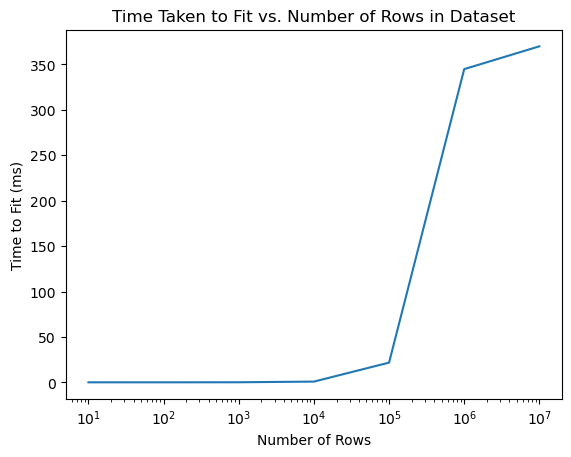

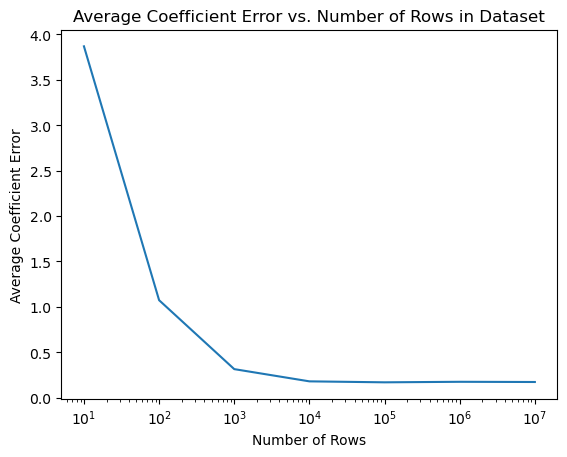

In [4]:
dataset = Dataset.generate(100, 4, 1000000, lambda x:x)

runtimes, errors = [], []
for i in range(1, 8):
    size = 10**i
    dataset_prime = dataset.truncate(size)
    runtime, error = measure_iterations(OLS, dataset_prime)
    errors.append(error)
    runtimes.append(runtime * 1000)
    
plt.xscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Time to Fit (ms)")
plt.title("Time Taken to Fit vs. Number of Rows in Dataset")
plt.plot([10**i for i in range(1, 8)], runtimes)
plt.show() 

plt.xscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Average Coefficient Error")
plt.title("Average Coefficient Error vs. Number of Rows in Dataset")
plt.plot([10**i for i in range(1, 8)], errors)
plt.show()

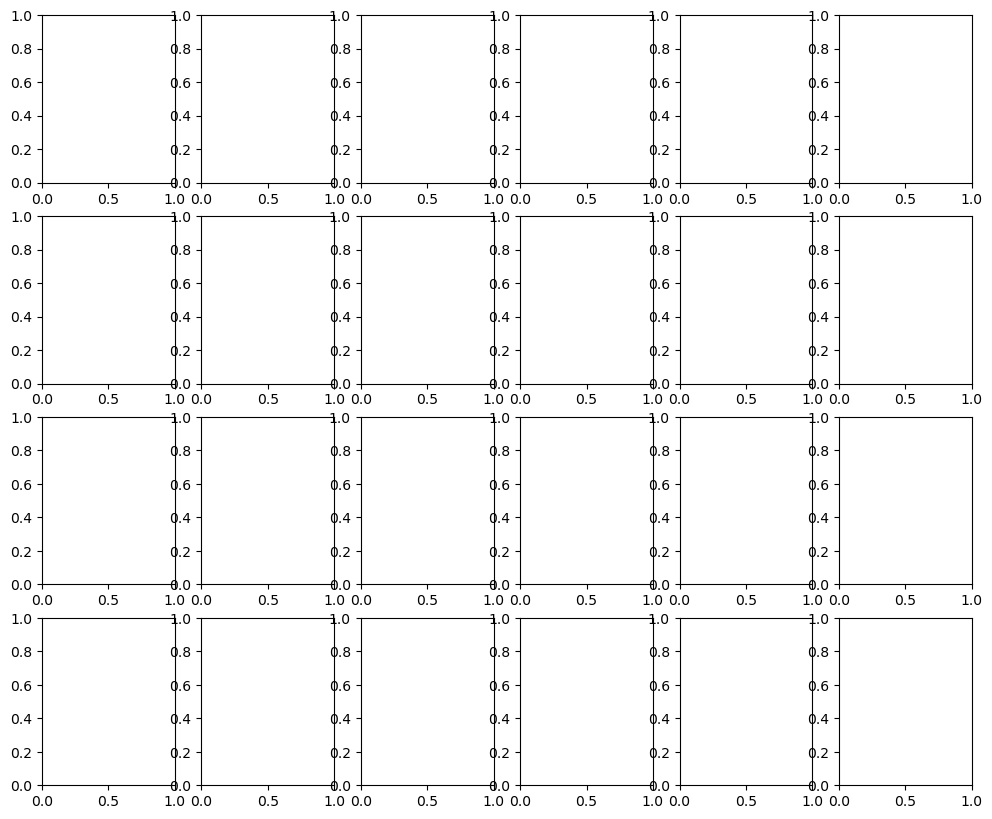

In [5]:
functions = {
    "Linear": lambda x: x,
    "Quadtratic": lambda x: x**2,
    "Cosine": lambda x: np.cos(x),
    "Exponential": lambda x: np.exp(x)
}

models = {
    "OLS": OLS,
    "WLS": WLS,
    "GLS": GLS,
    "RecursiveLS": RecursiveLS,
    "GLSAR": GLSAR,
    "RollingOLS": RollingOLS
}

fig, axes = plt.subplots(4, 6, figsize=(12, 10))


